In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage import measure
from skimage.color import rgb2grey

r = rgb2grey(mpimg.imread('image (2).png'))

# Find contours at a constant value of 0.8
contours = measure.find_contours(r, 0.1)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, interpolation='nearest', cmap=plt.cm.gray)

for contour in (contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

/usr/local/lib/python2.7/dist-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/usr/local/lib/python2.7/dist-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/usr/local/lib/python2.7/dist-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/usr/local/lib/python2.7/dist-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/usr/local/lib/python2.7/dist-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility.

<Figure size 640x480 with 1 Axes>

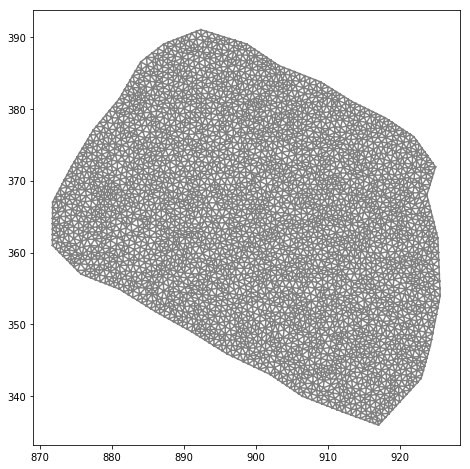

In [3]:
from dolfin import *
from mshr import *

# Select the biggest contour
max_contour = sorted(contours, key=lambda x:len(x), reverse=True)[185]

# Generate the mesh
domain_vertices = [Point(x,y) for x,y in max_contour][::8]

n = 48
geometry = Polygon(domain_vertices)
mesh = generate_mesh(geometry,n)
plt.figure(figsize=(8,8))
plot(mesh)

In [4]:
V = FunctionSpace(mesh, 'Lagrange', 1)
bc = DirichletBC(V, 0.0, DomainBoundary())
u, v = TrialFunction(V), TestFunction(V)

a = inner(grad(u), grad(v))*dx
L = Constant(0.0)*v*dx
m = u*v*dx

A, _ = assemble_system(a, L, bc)
B = assemble(m)

print "Discrete space size: %d"%V.dim()
eigensolver = SLEPcEigenSolver(as_backend_type(A), as_backend_type(B))
#prm = eigensolver.parameters
#info(prm, True)
eigensolver.parameters['spectrum'] = 'smallest magnitude'

eigensolver.solve(200)
r, c, rx, cx = eigensolver.get_eigenpair(0)
print(r,c , rx, cx)

Discrete space size: 3848
(0.010402858990091553, 0.0, <dolfin.cpp.la.PETScVector; proxy of <Swig Object of type 'std::shared_ptr< dolfin::PETScVector > *' at 0x7ffb8c16ede0> >, <dolfin.cpp.la.PETScVector; proxy of <Swig Object of type 'std::shared_ptr< dolfin::PETScVector > *' at 0x7ffb8c16ef30> >)


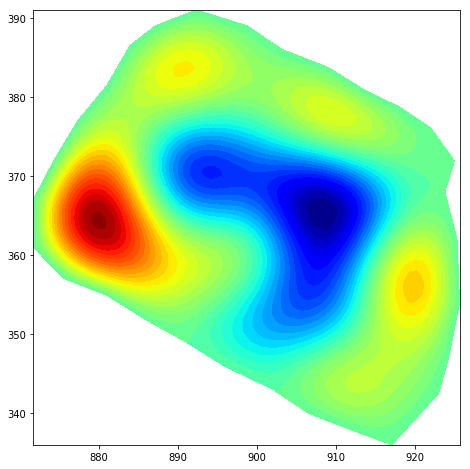

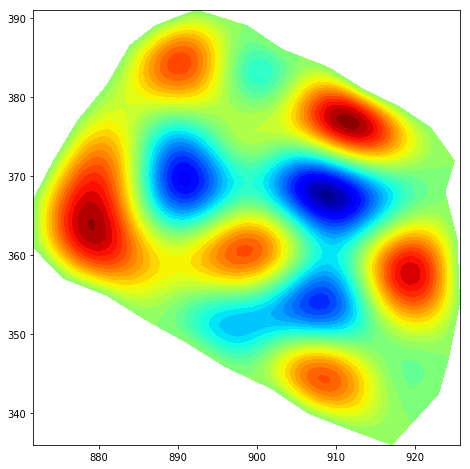

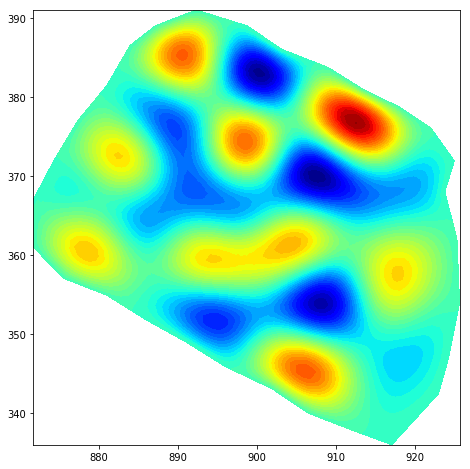

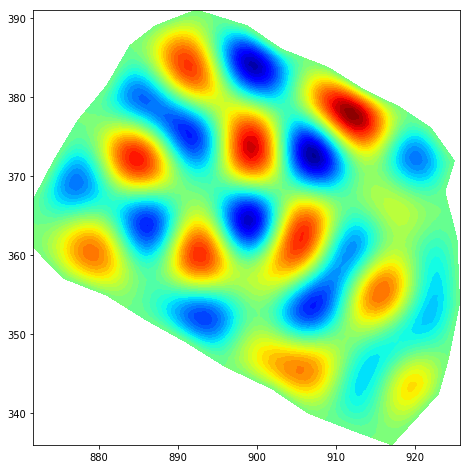

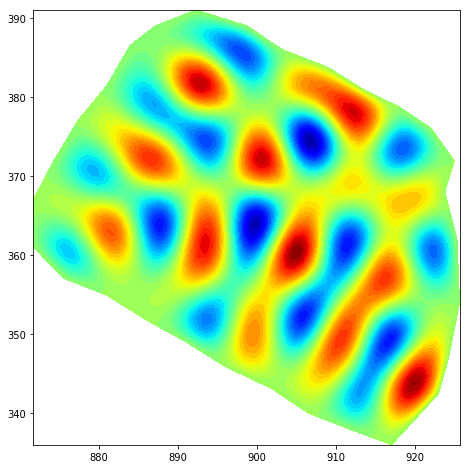

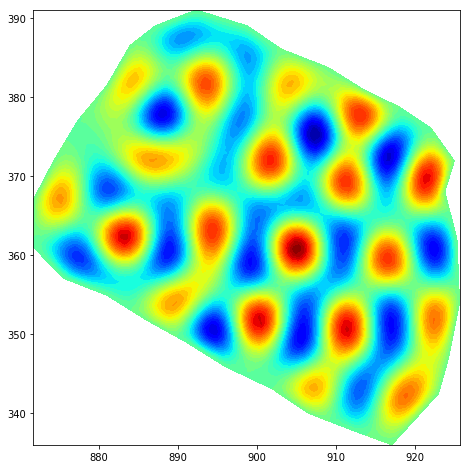

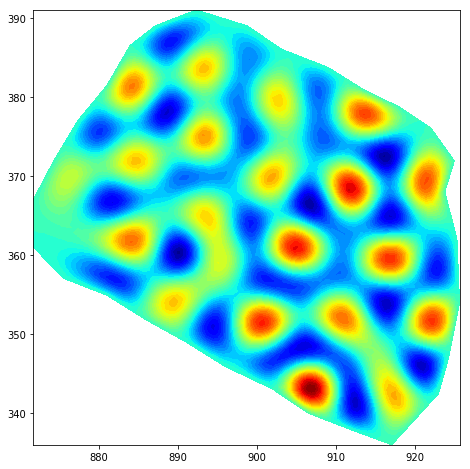

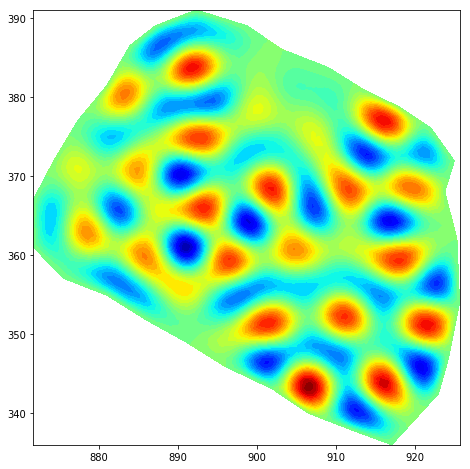

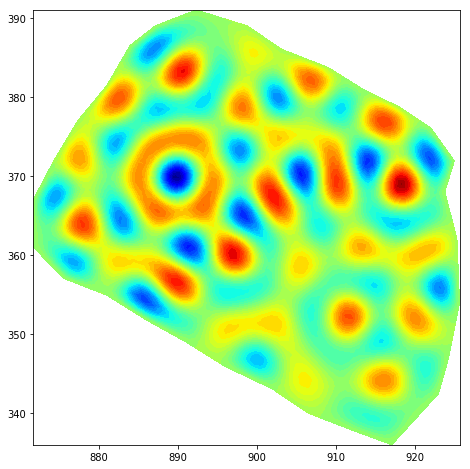

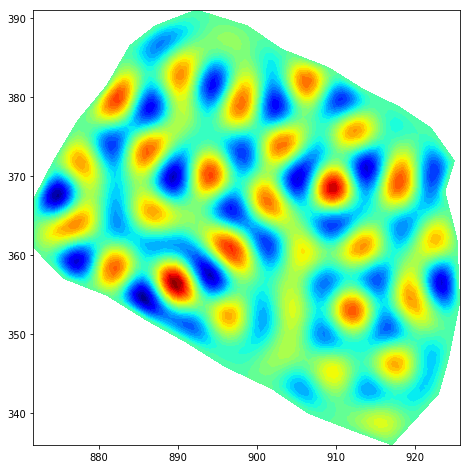

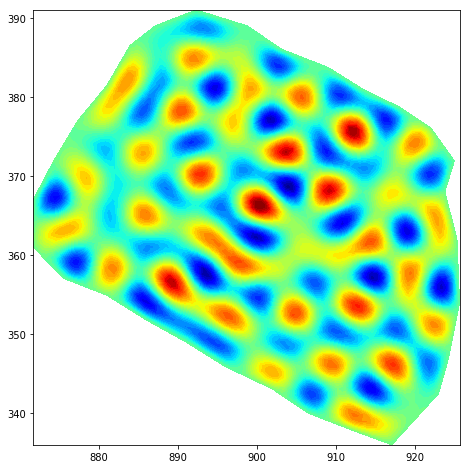

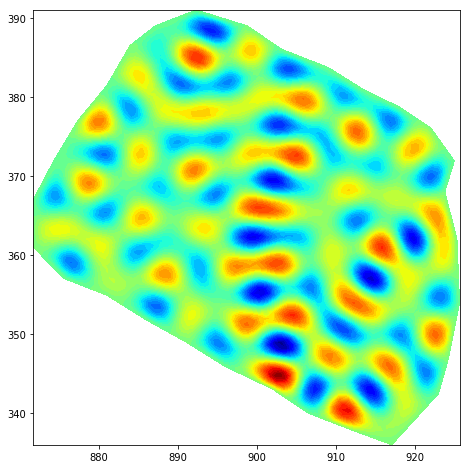

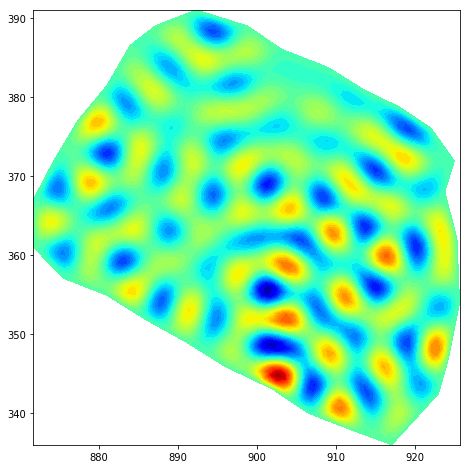

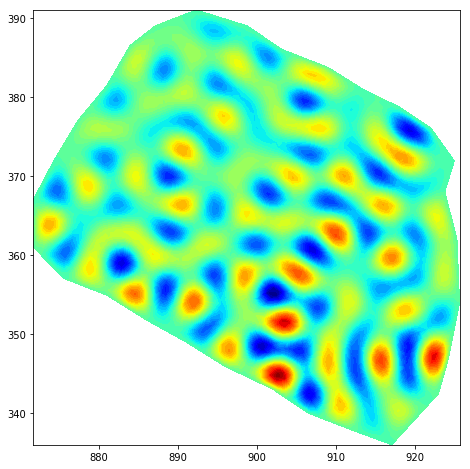

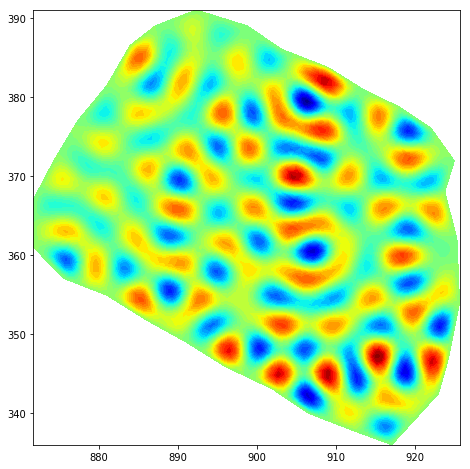

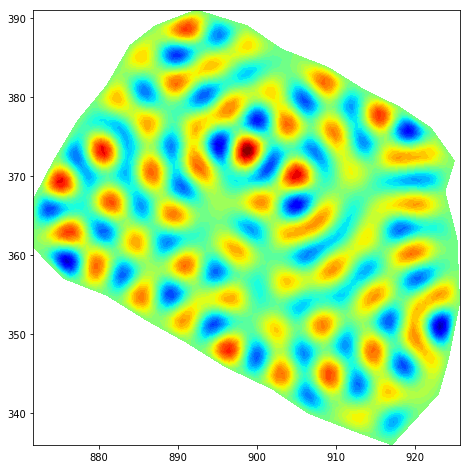

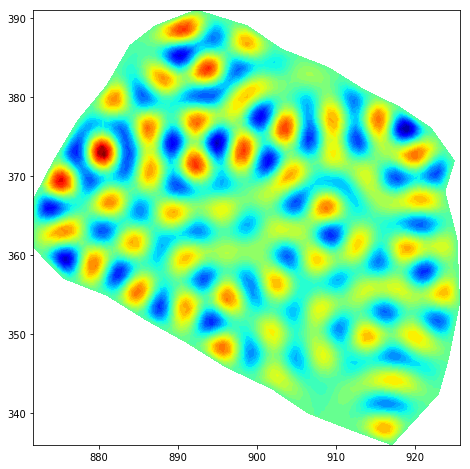

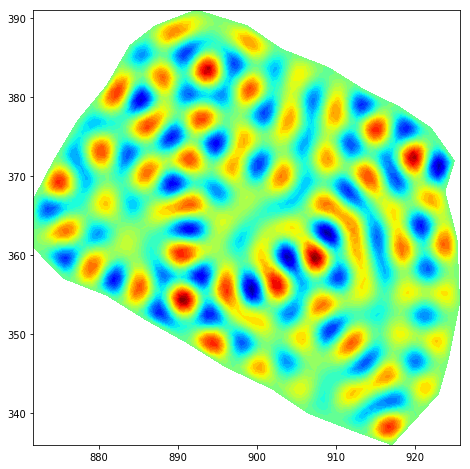

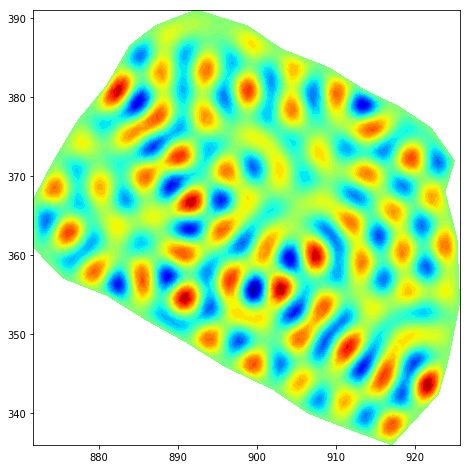

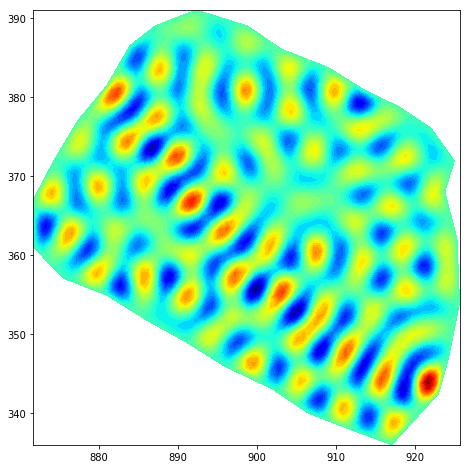

In [5]:
def lambd(k, t):
    # This function describe the evolution of the wavenumber. It's behavior is shown here https://www.desmos.com/calculator/eakf1fgagr
    # The parameters were chosen from the eigenvalues of the eigenfunctions.
    return 1-100*(k-t-0.0104095921342)*(k-t-0.0441421740478)
eig_list = []
for t in range(20):
    r, c, rx, cx = eigensolver.get_eigenpair(0)
    eig = Function(V)
    eig_vec = eig.vector()
    eig_vec[:] = rx
    eig = project(eig/dolfin.fem.norms.norm(eig, norm_type='L2'), V)
    eig = project(eig*exp(lambd(r, t*1.6/20)))
    for k in range(1, 201):
        r, c, rx, cx = eigensolver.get_eigenpair(k)
        wk = Function(V)
        wk_vec = wk.vector()
        wk_vec[:] = rx
        wk = project(wk/dolfin.fem.norms.norm(wk, norm_type='L2'), V)
        eig = project(eig + wk*exp(lambd(r, t*1.6/20)))
    plt.figure(figsize=(8,8))
    eig_list.append(eig)
    plot(eig, cmap = 'jet')

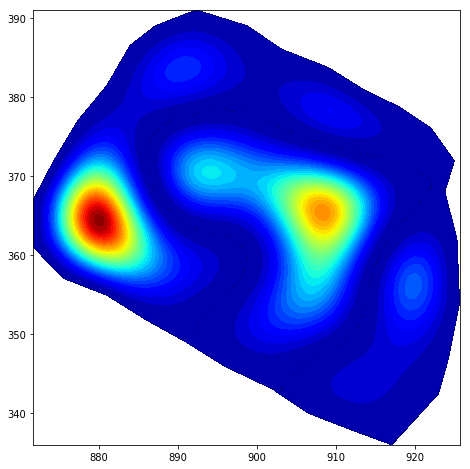

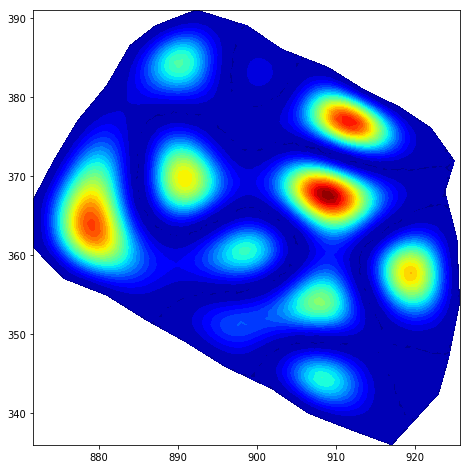

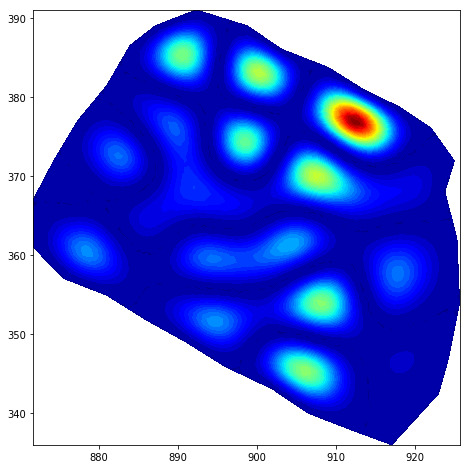

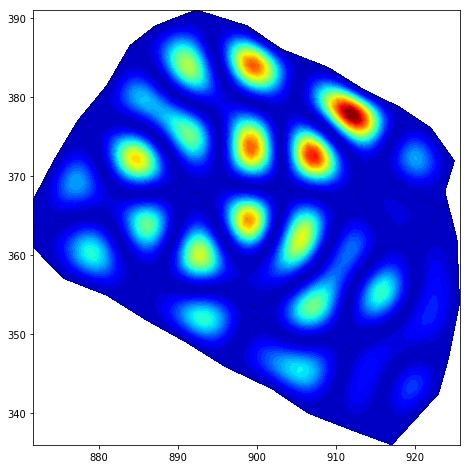

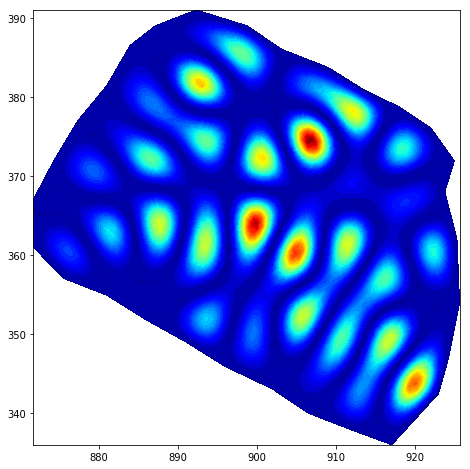

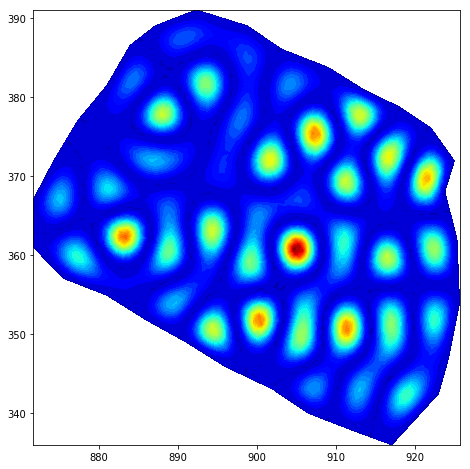

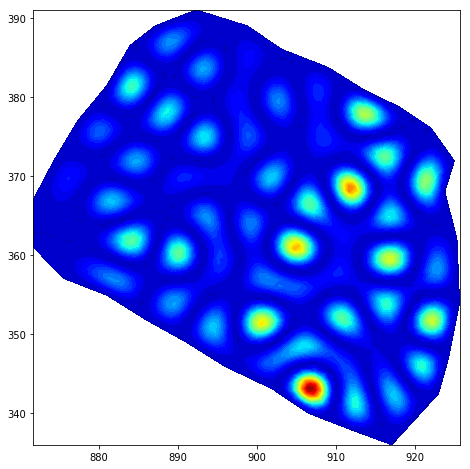

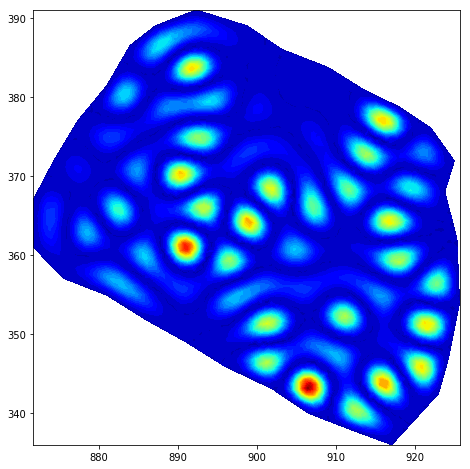

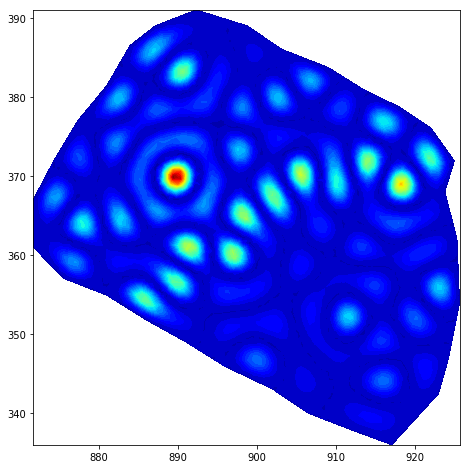

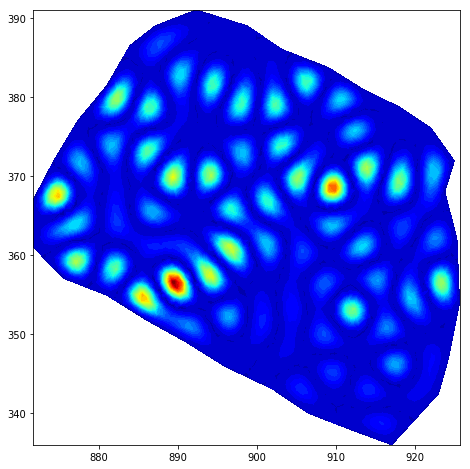

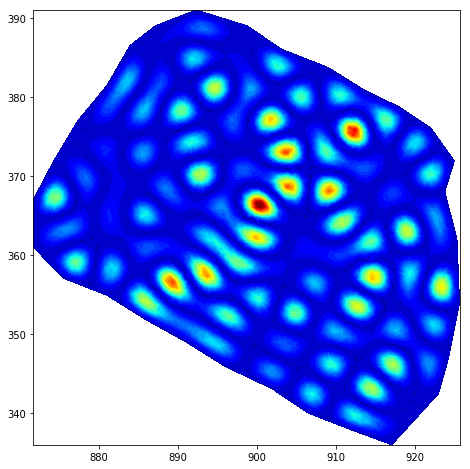

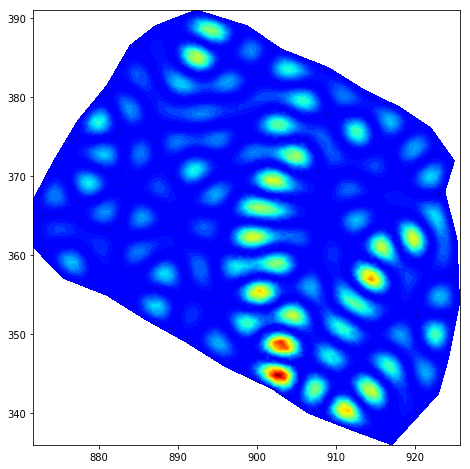

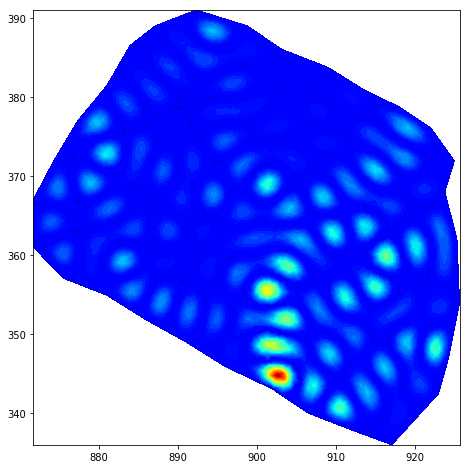

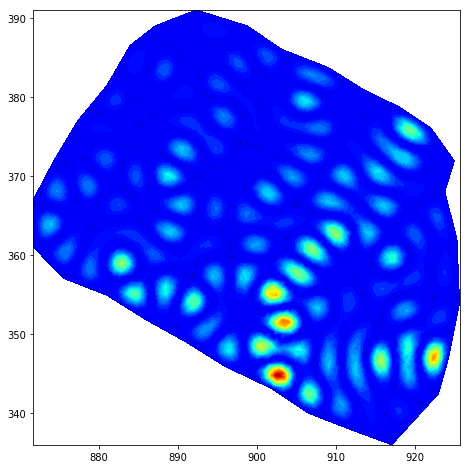

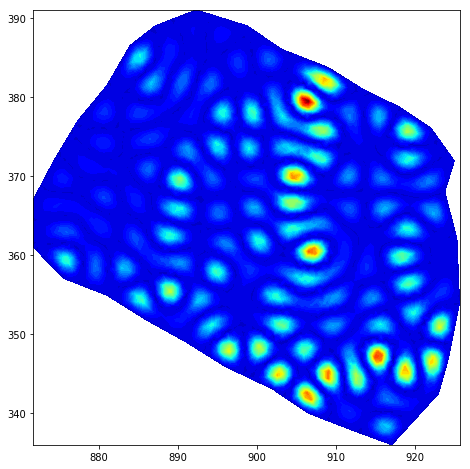

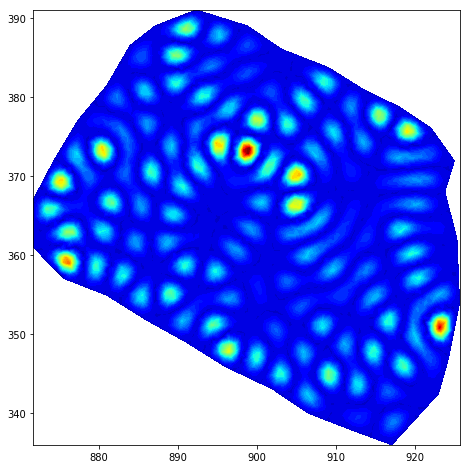

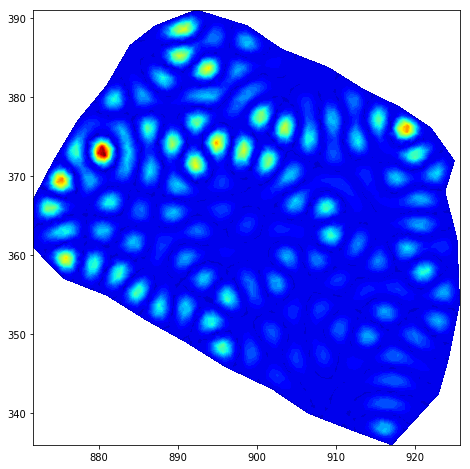

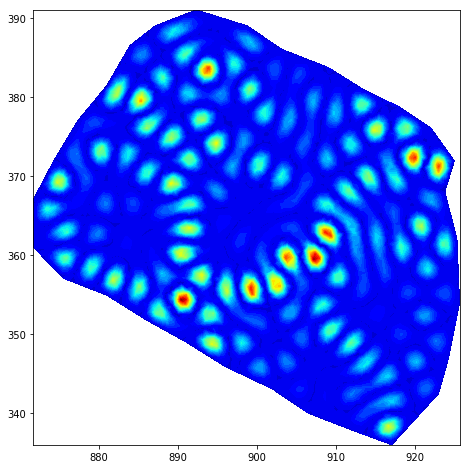

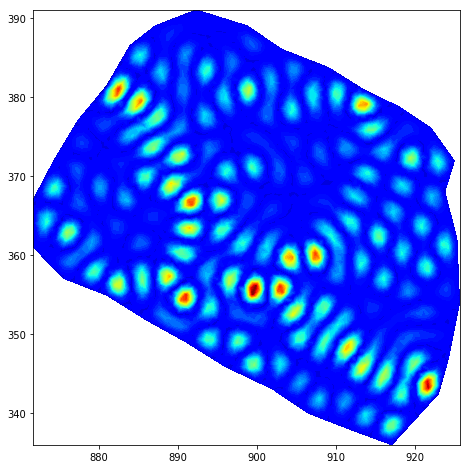

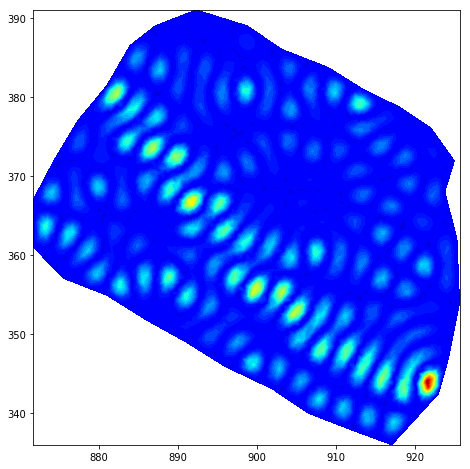

In [6]:
for eig in eig_list:
    plt.figure(figsize=(8,8))
    plot(eig*eig, cmap = 'jet')

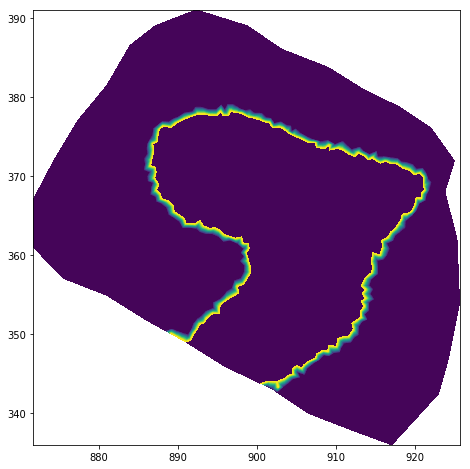

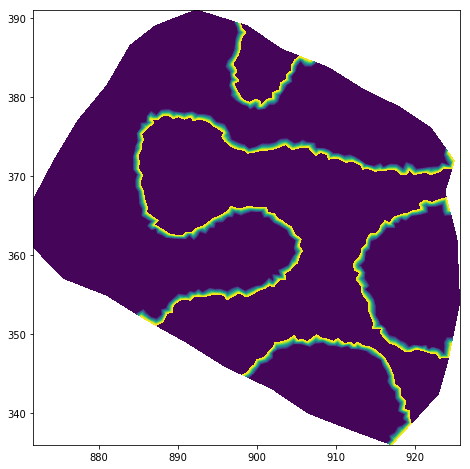

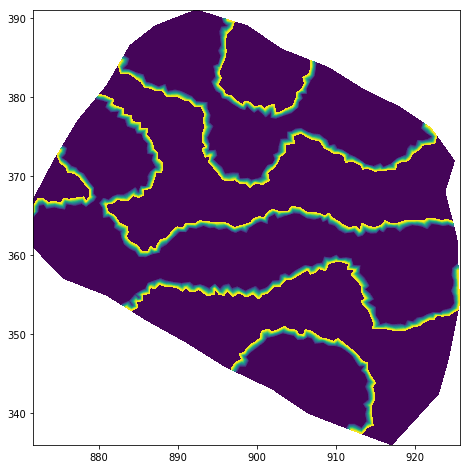

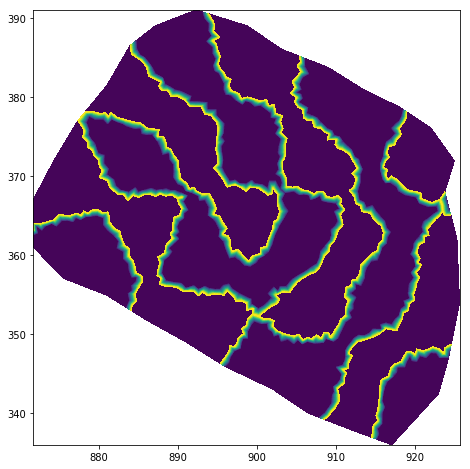

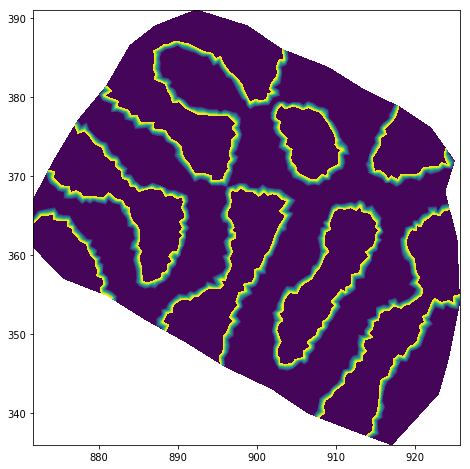

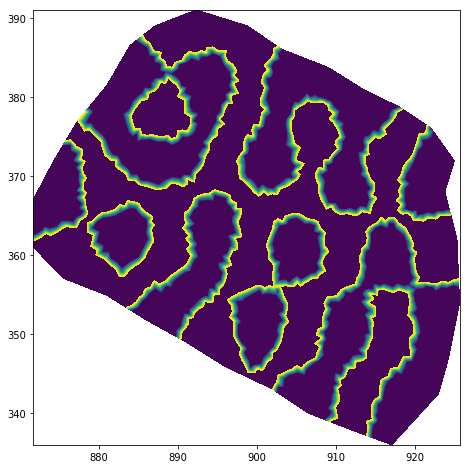

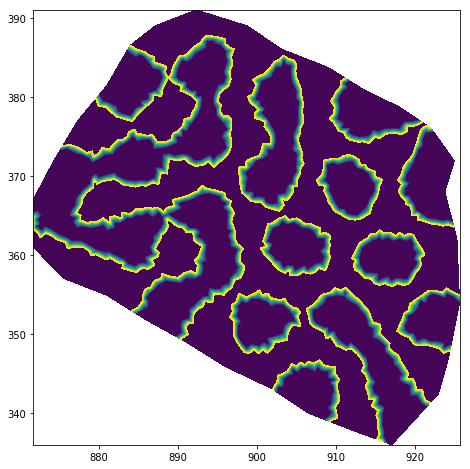

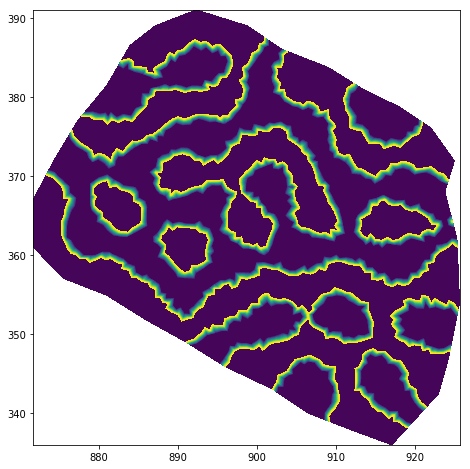

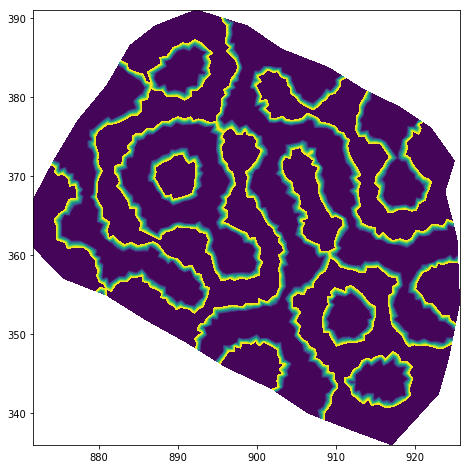

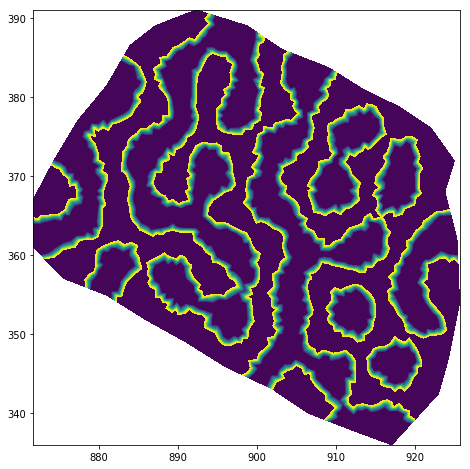

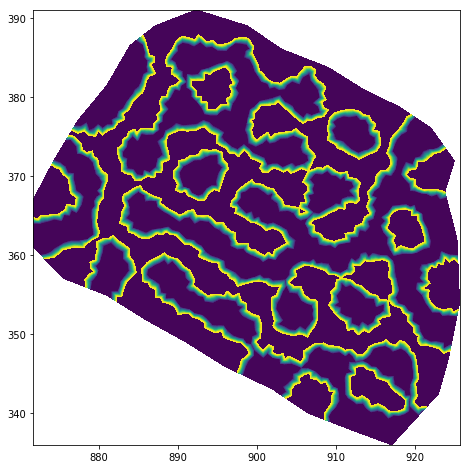

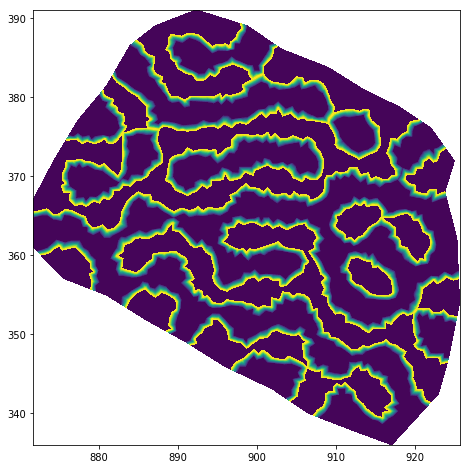

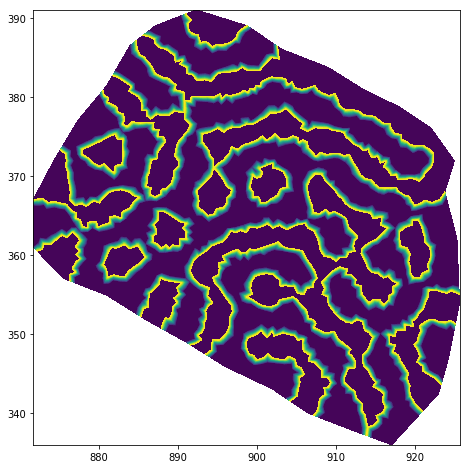

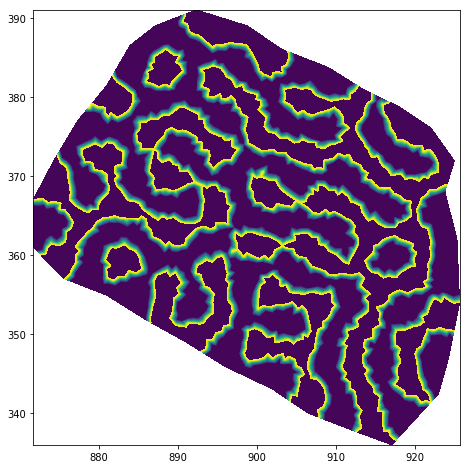

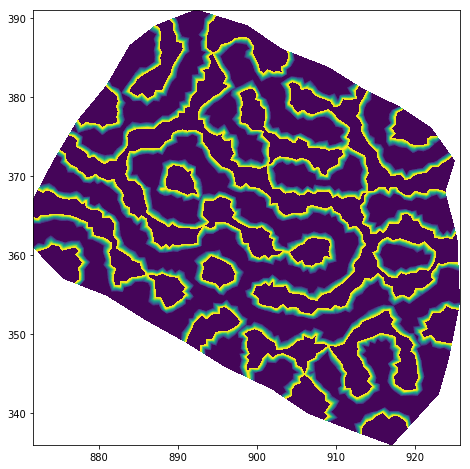

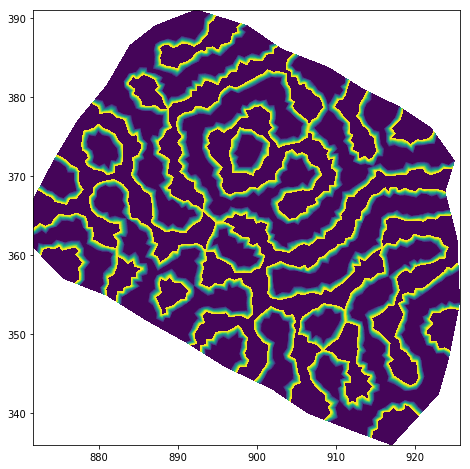

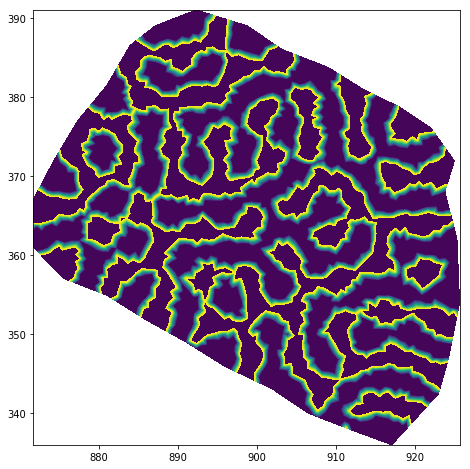

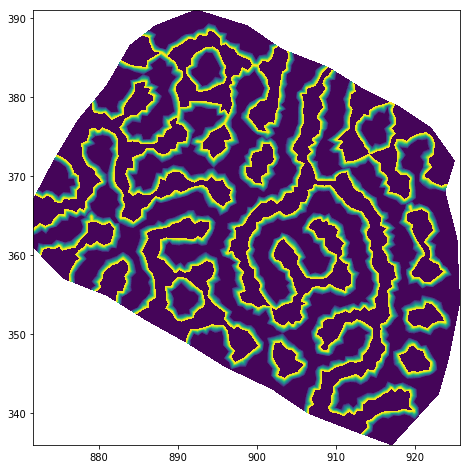

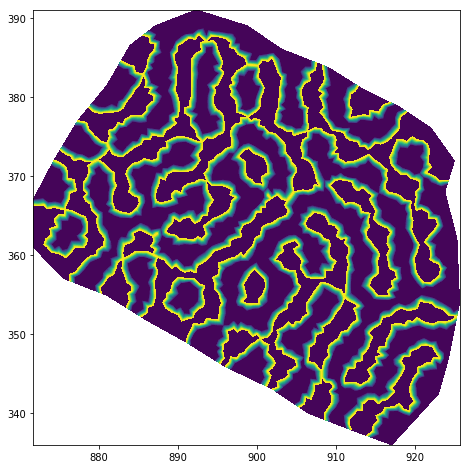

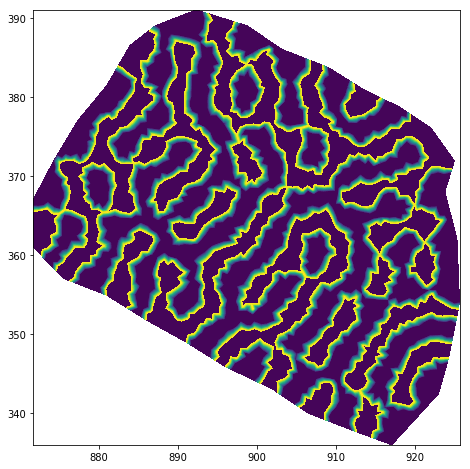

In [7]:
def division(eig):
    aux = project(eig, V)
    aux_vec = aux.vector()
    for j in range(len(aux.vector())):
        v = aux.vector()[j]
        if v>0:
            aux.vector()[j] = 1
        else:
            aux.vector()[j] = 0

    plt.figure(figsize=(8,8))
    plot(aux)

    aux = project(eig, V)
    aux_vec = aux.vector()
    for j in range(len(aux.vector())):
        v = aux.vector()[j]
        if v<0:
            aux.vector()[j] = 1
        else:
            aux.vector()[j] = 0


    plot(aux)
    
for eig in eig_list:
    division(eig)